In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models

import matplotlib.pyplot as plt
import imageio.v3 as imageio

from torch.utils.data import Dataset, DataLoader

# MODELLI

Modelli scelti:
* [R-CNN con backbone AlexNet](https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3)
* [SPPNet con backbone ZF-5](https://arxiv.org/pdf/1406.4729)
* [Faster R-CNN con backbone VGG16](https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3)

## R-CNN (AlexNet)

In [2]:
# Carica il backbone AlexNet
alexnet = models.alexnet(pretrained=True)

# Costruisci l'architettura R-CNN (personalizza in base alle tue esigenze)
class RCNN(nn.Module):
    def __init__(self, backbone):
        super(RCNN, self).__init__()
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        # Aggiungi livelli completamente connessi e ROI pooling
        # Definisci qui ulteriori strati
        
    def forward(self, x):
        x = self.backbone(x)
        # Implementa forward pass specifico per R-CNN
        return x

rcnn_model = RCNN(alexnet)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 158MB/s]


## SPPNet (ZF-5)

In [3]:
class SPPNet(nn.Module):
    def __init__(self):
        super(SPPNet, self).__init__()
        # Definisci il modello ZF-5 (convoluzioni e pooling)
        # Implementa i livelli SPP

    def forward(self, x):
        # Calcola il forward pass con SPP
        return x

sppnet_model = SPPNet()

## Faster R-CNN (VGG16)

In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Usa il backbone VGG16
vgg16_backbone = models.vgg16(pretrained=True).features

# Carica Faster R-CNN con backbone personalizzato
faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.backbone = vgg16_backbone

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

# DATASET

Il nostro dataset è xView, un'analisi preliminare del dataset è presente nel [documento](https://medium.com/picterra/the-xview-dataset-and-baseline-results-5ab4a1d0f47f) linkato.


Questo dataset rappresentava il migliore per il benchmarking di visione artificiale satellitare. La documentazione tecnica spiega che i dati sono ottenuti dai satelliti **WorldView-3**, con una distanza di campionamento al suolo uniforme di 0,3 metri. Ciò conferisce una risoluzione più elevata e omogenea rispetto alla maggior parte degli altri dataset satellitari esistenti all'epoca, molti dei quali si basano invece su fotografie aeree. Quest'ultime, infatti, presentano differenze nella distorsione causate dall'angolo di ripresa, poiché sono scattate da velivoli a bassa quota. 

Il dataset **xView** offre una copertura geografica ampia e diversificata, includendo anche aree meno sviluppate e urbanizzate, fornendo quindi una maggiore varietà di scenari rispetto a dataset più convenzionali. 

## [DATASET PREPROCESSING](https://www.kaggle.com/code/ollypowell/xview-dataset-to-yolo-and-coco-format)

Utilizziamo un processo di preprocessing per il dataset **xView**. L'obiettivo è:

1. **Pulizia e riformattazione**: Si parte dal dataset grezzo e lo si prepara per l'addestramento di modelli di intelligenza artificiale per il rilevamento di oggetti.
2. **Suddivisione in tile**: Poiché le immagini satellitari sono molto grandi, vengono suddivise in "pezzi" più piccoli (tile) per facilitare l'elaborazione. I bounding box, che definiscono le posizioni degli oggetti nelle immagini, vengono ridimensionati in modo che corrispondano ai nuovi pezzi.
3. **Ottimizzazione del formato**: Le immagini TIFF, che occupano molto spazio, vengono convertite in formato JPG, molto più leggero.
4. **Personalizzazione**: È possibile scegliere la dimensione delle immagini finali e come suddividere i dati per l'addestramento.

Questo processo riduce significativamente la dimensione del dataset, rendendolo più gestibile, senza sacrificare le informazioni necessarie per l'addestramento di modelli come **YOLOv5**.


In [5]:
from pathlib import Path
import pandas as pd
import cv2
import os
import numpy as np
from os import sep
import shutil
import json
import yaml
import matplotlib.pyplot as plt
import random
import time
from tqdm.notebook import tqdm_notebook
import concurrent.futures
import multiprocessing as mp

### Setup
To run locally without changing the filepath setup, just copy the relative file structure below:

- For the images: My_Project/Data/X_view/train_images
- For the labels:  My_Project/Data/X_view/train_labels/xView_train.geojson
- For this notebook: My_Project/Python/reformat_yolo.ipynb

You can change the 'My_Project', 'Python', 'reformat_xview.ipynb' to whatever you like.

In [6]:
#Data sources
DATA_FLDR_NM = 'Data'
IN_DATASET_NM = 'xview-dataset'
IMAGE_FLDR_NM = 'train_images'
IN_LABELS_FLDR_NM = 'train_labels'
LABELS_XML_NM = 'xView_train.geojson'

#Output folders and file names
OUT_DATASET_NM = 'xview-yolo-dataset'
CLASS_MAP_JSON_NM = 'xView_class_map.json'
OUT_COCO_JSON_NM = 'COCO_annotations.json'
OUT_IMAGE_FLDR_NM = 'images'
OUT_CFG_FLDR_NM = 'YOLO_cfg'
OUT_DATAFRAME_NM = 'xview_labels.parquet'
YAML_NM = 'xview_yolo.yaml'
CHUNK_WIDTH = 640  # width of the images being created
CHUNK_HEIGHT = 640
MIN_CHUNK_HEIGHT = 320 # no images will be kept if the image chunk is smaller than this
MIN_CHUNK_WIDTH = 320
IMAGE_WRITING = True #True to re-perform image cropping, False just to regenerated other data
TEST_FRACTION = 0.1
JPEG_COMPRESSION = 95 # For the saved files
VAL_FRACTION = 0.1
RANDOM_SEED = 2023
DEBUG = False

in_kaggle = os.environ.get('PWD') == '/kaggle/working'
if in_kaggle:
    in_dataset_pth = Path('/kaggle/input/xview-dataset')
    out_dataset_pth = Path('/kaggle/working/')
    future_ds_img_fldr = Path(f'/kaggle/input/{OUT_DATASET_NM}/{OUT_IMAGE_FLDR_NM}')
    future_ds_cfg_fldr = Path(f'/kaggle/input/{OUT_DATASET_NM}/{OUT_CFG_FLDR_NM}')
else:
    in_dataset_pth = Path("your/path/to/where/you/put/original/dataset")
    #in_dataset_pth = Path.cwd().parent / DATA_FLDR_NM / IN_DATASET_NM  #or put it here
    out_dataset_pth = Path.cwd().parent / DATA_FLDR_NM / OUT_DATASET_NM  #change to suit
    future_ds_img_fldr = out_dataset_pth / DATA_FLDR_NM / OUT_DATASET_NM / OUT_IMAGE_FLDR_NM
    future_ds_cfg_fldr = out_dataset_pth / DATA_FLDR_NM /OUT_DATASET_NM / OUT_CFG_FLDR_NM 

labels_json_pth = in_dataset_pth / IN_LABELS_FLDR_NM / LABELS_XML_NM
img_fldr_pth = in_dataset_pth / IMAGE_FLDR_NM / IMAGE_FLDR_NM
save_images_fldr_pth = out_dataset_pth / OUT_IMAGE_FLDR_NM 
out_data_parquet_pth = out_dataset_pth / OUT_DATAFRAME_NM
out_json_map_pth = out_dataset_pth / CLASS_MAP_JSON_NM 
class_map_pth = out_dataset_pth / CLASS_MAP_JSON_NM
cfg_fldr_pth = out_dataset_pth / OUT_CFG_FLDR_NM
coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM
yolo_yaml_pth = cfg_fldr_pth / YAML_NM
train_txt_pth = cfg_fldr_pth / 'train.txt'
val_txt_pth = cfg_fldr_pth / 'train.txt'
test_txt_pth = cfg_fldr_pth / 'test.txt'

def make_empty_dir(directory):
    if directory.is_dir():
        shutil.rmtree(directory)
    os.makedirs(directory)

make_empty_dir(cfg_fldr_pth)
if IMAGE_WRITING:
    make_empty_dir(save_images_fldr_pth)

random.seed(RANDOM_SEED)

print(f'The input images are found at {cfg_fldr_pth}')
print(f'The input labels are found at  {labels_json_pth}')
print(f'Configuration files will be saved to {cfg_fldr_pth}')
print(f'YOLO image files will be saved to {save_images_fldr_pth}')

The input images are found at /kaggle/working/YOLO_cfg
The input labels are found at  /kaggle/input/xview-dataset/train_labels/xView_train.geojson
Configuration files will be saved to /kaggle/working/YOLO_cfg
YOLO image files will be saved to /kaggle/working/images


### Helper Functions

In [7]:
def get_boxes(in_df, class_lst=[]):
    if class_lst:
        in_df = in_df[in_df['TYPE_ID'].isin(class_lst)]
    unique_images = in_df.IMAGE_ID.unique().tolist()
    boxs = {}

    for image in tqdm_notebook(unique_images):
        mask = in_df['IMAGE_ID'] == image
        masked = in_df[mask][['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX']]
        boxs[image] = masked.values.tolist()
    return boxs


def print_first_n_lines(file_path, n):
    try:
        with open(file_path, 'r') as file:
            for line_num, line in enumerate(file, 1):
                if line_num > n:
                    break
                print(line.strip())
    except FileNotFoundError:
        print('Unable to open file')


def load_image(file_pth): #for display
    image_obj = cv2.imread(file_pth)
    image_obj = cv2.cvtColor(image_obj, cv2.COLOR_BGR2RGB)
    return image_obj


def load_bgr_image(file_pth): # for processing only, no need to visualise the image
    image_obj = cv2.imread(file_pth)
    return image_obj

'''The colors are displaying a bit odd intermittently on Ubuntu.  I haven't got to the bottom of why, but suspect it has
something to do with the pixel depth.  Shouldn't actually matter for the purpose of making the training dataset.
'''
def display_images(image_lst, boxes_dictionary, image_fldr, max_images=6, no_cols=1, text=False,  class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims//no_cols + (display_ims % no_cols > 0)
    fig, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))
    axs = axs.flatten()
    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = str(image_fldr / img_nm)
        img = load_image(image_path)

        # create a bounding box with the data & draw it
        if img_nm in boxes_dictionary:
            for box in boxes_dictionary[img_nm]:
                box_id, x_min, y_min, x_max, y_max = box
                x_min, y_min, x_max, y_max = int(x_min), int(y_max), int(x_max), int(y_min)
                # (left top), (right, bottom) == (XMIN, YMIN), (XMAX, YMAX)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                if text:
                    if class_map:
                        box_label = class_map[box_id]
                    else:
                        box_label = str(box_id)
                    cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)

        # Show image with bboxes
        axs[k].set_title(f"Image {img_nm}", fontsize = 12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    # Display all the images
    plt.tight_layout()
    plt.show()
    return

#Convert YOLO to CV2 rectangle (l,t),(r,b)
def get_corners(x_cen, y_cen, an_width, an_height, im_width, im_height):
    x_cen, y_cen, an_width, an_height = float(x_cen), float(y_cen), float(an_width), float(an_height)
    left = (x_cen - an_width/2)*im_width
    top = (y_cen - an_height/2)*im_height
    right = (x_cen + an_width/2)*im_width
    bottom = (y_cen + an_height/2)*im_height
    return int(left), int(top), int(right), int(bottom)


def display_yolo_images(image_lst, image_fldr, max_images=6, no_cols=1, text=False,  class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims//no_cols + (display_ims % no_cols > 0)
    _, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))
    axs = axs.flatten()
    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = image_fldr / img_nm
        text_fn = image_path.stem + '.txt'
        boxes_path = image_fldr / text_fn
        img = load_image(str(image_path))
        im_h, im_w, _ = img.shape
        with open(boxes_path) as text_file:
            annotations = [line.rstrip().split() for line in text_file]

        # create a bounding box with the data & draw it
        for ann in annotations:
                class_id = ann[0]
                x_centre, y_centre, w, h = ann[1], ann[2], ann[3], ann[4]
                x_min, y_min, x_max, y_max = get_corners(x_centre, y_centre, w, h, im_w, im_h)
                # (left top), (right bottom) == (XMIN, YMIN), (XMAX, YMAX)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                if text:
                    if class_map:
                        box_label = class_map[int(class_id)]
                    else:
                        box_label = str(class_id)
                    cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)

        # Show image with bboxes
        axs[k].set_title(f"Image {img_nm}", fontsize = 12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    # Display all the images
    plt.tight_layout()
    plt.show()
    return


# For a given square within a chunk of a larger image, find any boxes in it
# Return the boxes in YOLO format relative to the chunk boundary
def match_boxes(box_list, chnk_lims):
    boxes_lists = []
    le, to = chnk_lims[0], chnk_lims[1]  # chunk_limits = [c, r, chunk_w, chunk_h]
    w, h  = chnk_lims[2], chnk_lims[3]
    for box in box_list:
        o_left, o_top, o_right, o_bottom = box[1], box[2], box[3], box[4]
        left, right = (o_left - le)/w, (o_right - le)/w  # translate and normalise
        top, bottom = (o_top - to)/h, (o_bottom - to)/h

        h_match = (0 <= left < 1) or (0 < right <= 1)
        v_match = (0 <= top < 1) or (0 < bottom <= 1)

        if v_match and h_match:
            clipped = np.clip([left, top, right, bottom], a_min=0, a_max=1)
            l, t, r, b = clipped[0], clipped[1], clipped[2], clipped[3]
            bounding_box = [str(box[0]),
                            str(round((l + r)/2, 5)),
                            str(round((t + b)/2, 5)),
                            str(round(r-l, 5)),
                            str(round(b-t, 5))]
            boxes_lists.append(bounding_box)
    return boxes_lists

### Data Extraction and Cleaning

In [8]:
with open(labels_json_pth, 'r') as infile:
    data = json.load(infile)
    keys = list(data.keys())

feature_list = data['features']
COLUMNS = ['IMAGE_ID', 'TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX', 'LONG', 'LAT']

data = []
for feature in tqdm_notebook(feature_list):
    properties = feature['properties'] # a dict
    img_id = properties['image_id']  # '389.tif'
    type_id = properties['type_id']
    bbox = properties['bounds_imcoords'].split(",")  # eg '1917,38,1958,64'
    geometry = feature ['geometry']
    coords = geometry['coordinates'][0] #for some reason it's a list of lists
    long = coords[0][0] / 2  + coords[2][0] / 2
    lat = coords[0][1] / 2  + coords[1][1] / 2
    one_row = [img_id, type_id, bbox[0], bbox[1], bbox[2], bbox[3], long, lat]
    data.append(one_row)

instances = len(data)
print(f'There are {instances} object instances in the original dataset')

  0%|          | 0/601937 [00:00<?, ?it/s]

There are 601937 object instances in the original dataset


Extracting the columns of interest only

In [9]:
df = pd.DataFrame(data, columns = COLUMNS)
df[['XMIN', 'YMIN', 'XMAX', 'YMAX']] = df[['XMIN', 'YMIN', 'XMAX', 'YMAX']].apply(pd.to_numeric)
df.head()

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,73,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,73,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,73,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,73,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,73,2671,838,2714,869,-90.531766,14.567149


Removing two erroneous annotation class labels (See [EDA of the xView dataset](https://www.kaggle.com/code/ollypowell/xview-dataset-eda))

In [10]:
df = df[(df.TYPE_ID != 75) & (df.TYPE_ID != 82)]   # removing erroneous labels
print(f'{instances - len(df)} rows removed, leaving {len(df)} rows')

79 rows removed, leaving 601858 rows


In [11]:
df.head()

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,73,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,73,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,73,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,73,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,73,2671,838,2714,869,-90.531766,14.567149


Also removing anything from image 1395, this image does not exist in the dataset

In [12]:
old_length = len(df)
df = df[df.IMAGE_ID != '1395.tif']
print(f'{old_length - len(df)} rows removed, leaving {len(df)}')
df.head()

131 rows removed, leaving 601727


,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,73,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,73,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,73,2687,1338,2740,1399,-90.531694,14.565379
3,2355.tif,73,2691,1201,2730,1268,-90.531704,14.565838
4,2355.tif,73,2671,838,2714,869,-90.531766,14.567149


Also it's useful to convert the type IDs into a continuous sequence from 0 to 59 for the 60 categories.  The original competition labels were not arranged this way. The dictionary below is the original mapping from the competition website.

In [13]:
old_dict = {
    11:'Fixed-wing Aircraft', 12:'Small Aircraft', 13:'Passenger/Cargo Plane', 15:'Helicopter',
    17:'Passenger Vehicle', 18:'Small Car', 19:'Bus', 20:'Pickup Truck', 21:'Utility Truck',
    23:'Truck', 24:'Cargo Truck', 25:'Truck Tractor w/ Box Trailer', 26:'Truck Tractor',27:'Trailer',
    28:'Truck Tractor w/ Flatbed Trailer', 29:'Truck Tractor w/ Liquid Tank', 32:'Crane Truck',
    33:'Railway Vehicle', 34:'Passenger Car', 35:'Cargo/Container Car', 36:'Flat Car', 37:'Tank car',
    38:'Locomotive', 40:'Maritime Vessel', 41:'Motorboat', 42:'Sailboat', 44:'Tugboat', 45:'Barge',
    47:'Fishing Vessel', 49:'Ferry', 50:'Yacht', 51:'Container Ship', 52:'Oil Tanker',
    53:'Engineering Vehicle', 54:'Tower crane', 55:'Container Crane', 56:'Reach Stacker',
    57:'Straddle Carrier', 59:'Mobile Crane', 60:'Dump Truck', 61:'Haul Truck', 62:'Scraper/Tractor',
    63:'Front loader/Bulldozer', 64:'Excavator', 65:'Cement Mixer', 66:'Ground Grader', 71:'Hut/Tent',
    72:'Shed', 73:'Building', 74:'Aircraft Hangar', 76:'Damaged Building', 77:'Facility', 79:'Construction Site',
    83:'Vehicle Lot', 84:'Helipad', 86:'Storage Tank', 89:'Shipping container lot', 91:'Shipping Container',
    93:'Pylon', 94:'Tower'}

Making a new mapping from 0 to 59

In [14]:
old_keys = sorted(list(old_dict.keys()))
new_dict = {old_dict[x]:y for y, x in enumerate(old_keys)}
class_map_dict = {y:old_dict[x] for y, x in enumerate(old_keys)}
with open(out_json_map_pth, "w") as json_file:
    json.dump(class_map_dict, json_file)
print(class_map_dict)

{0: 'Fixed-wing Aircraft', 1: 'Small Aircraft', 2: 'Passenger/Cargo Plane', 3: 'Helicopter', 4: 'Passenger Vehicle', 5: 'Small Car', 6: 'Bus', 7: 'Pickup Truck', 8: 'Utility Truck', 9: 'Truck', 10: 'Cargo Truck', 11: 'Truck Tractor w/ Box Trailer', 12: 'Truck Tractor', 13: 'Trailer', 14: 'Truck Tractor w/ Flatbed Trailer', 15: 'Truck Tractor w/ Liquid Tank', 16: 'Crane Truck', 17: 'Railway Vehicle', 18: 'Passenger Car', 19: 'Cargo/Container Car', 20: 'Flat Car', 21: 'Tank car', 22: 'Locomotive', 23: 'Maritime Vessel', 24: 'Motorboat', 25: 'Sailboat', 26: 'Tugboat', 27: 'Barge', 28: 'Fishing Vessel', 29: 'Ferry', 30: 'Yacht', 31: 'Container Ship', 32: 'Oil Tanker', 33: 'Engineering Vehicle', 34: 'Tower crane', 35: 'Container Crane', 36: 'Reach Stacker', 37: 'Straddle Carrier', 38: 'Mobile Crane', 39: 'Dump Truck', 40: 'Haul Truck', 41: 'Scraper/Tractor', 42: 'Front loader/Bulldozer', 43: 'Excavator', 44: 'Cement Mixer', 45: 'Ground Grader', 46: 'Hut/Tent', 47: 'Shed', 48: 'Building', 49

Now we can convert the dataframe's old TYPE_IDs to their new values

In [15]:
df['TYPE_ID'] = df['TYPE_ID'].apply(lambda x: new_dict[old_dict[x]])
df.head(3)

,IMAGE_ID,TYPE_ID,XMIN,YMIN,XMAX,YMAX,LONG,LAT
0,2355.tif,48,2712,1145,2746,1177,-90.531640,14.566091
1,2355.tif,48,2720,2233,2760,2288,-90.531603,14.562313
2,2355.tif,48,2687,1338,2740,1399,-90.531694,14.565379


Just to check the data is loading sensibly, I'm displaying a couple of images with any transport related annotations.

  0%|          | 0/786 [00:00<?, ?it/s]

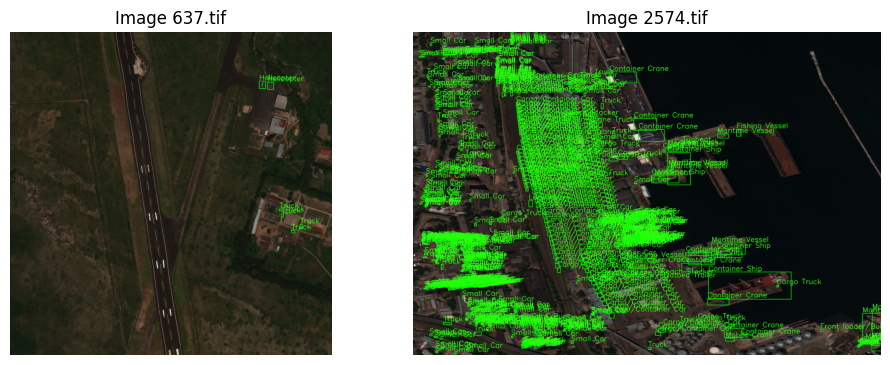

In [16]:
all_classes = list(class_map_dict.keys())
transport_only = [x for x in all_classes if x < 48]

boxes = get_boxes(df, transport_only)
images_for_display = random.choices(list(boxes.keys()), k=2)
display_images(images_for_display, boxes, img_fldr_pth, max_images=2, no_cols=2, text=True, class_map=class_map_dict) #adjust as desired

## Main Process
- Break up the large tif files into chunks
- Save those chunks as jpg files
- Check if any chunks contain annotations
- Reformat those annotations into YOLO format: x_center, y_center, width, height (all normalised)
- Write all annotations in YOLO format to a dictionary with the filename as a key

In [17]:
boxes_dict = get_boxes(df) # returns a dict of the form {filename:[['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX'],[..],[..],..]}

  0%|          | 0/846 [00:00<?, ?it/s]

In [18]:
def process_image(img_fn, 
                  dir_pth=img_fldr_pth, 
                  boxes=boxes_dict, 
                  out_dir=save_images_fldr_pth, 
                  c_height=CHUNK_HEIGHT, 
                  c_width=CHUNK_WIDTH,  
                  jpg_q=JPEG_COMPRESSION,
                  min_h=MIN_CHUNK_HEIGHT,
                  min_w=MIN_CHUNK_WIDTH,
                  writing=IMAGE_WRITING
                 ):
    
    labels_list = boxes[img_fn]
    img_pth = str(dir_pth / img_fn)
    im = load_bgr_image(img_pth)
    full_h, full_w, _ = im.shape
    y_boxes= {}
    f_names, widths, heights = [], [], []
    
    for r in range(0, full_h, c_height):
        for c in range(0, full_w, c_width):
            stem = img_fn.split('.')[0]
            fn = str(f"img_{stem}_{r}_{c}.jpg")
            out_pth = str(out_dir / fn)
            width = c_width
            height = c_height
            if r + height > full_h:
                height = full_h - r
            if c + width > full_w:
                width = full_w - c
            big_enough = (c_height > min_h) and (c_width > min_w)
            if big_enough:
                if writing:
                    cv2.imwrite(out_pth, im[r:r+height, c:c+height,:],  [int(cv2.IMWRITE_JPEG_QUALITY), jpg_q])
                # Find any boxes occurring in the chunk, and convert to YOLO format
                chunk_limits = [c, r, width, height]
                y_boxes[fn] = match_boxes(labels_list, chunk_limits)
                f_names.append(fn)
                widths.append(width)
                heights.append(height)
    return f_names, widths, heights, y_boxes

In [19]:
img_fns = df.IMAGE_ID.unique().tolist()
if DEBUG:
    img_fns = img_fns[:len(img_fns)//120]
    df = df[df['IMAGE_ID'].isin(img_fns)]

In [20]:
start_time = time.time()
num_threads = mp.cpu_count() 
overall_progress = tqdm_notebook(total=len(img_fns), desc="Creating and saving image tiles")
yolo_boxes= {}
file_names, widths, heights = [], [], []

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for f_names, c_widths, c_heights, y_boxes in executor.map(process_image, img_fns):
        file_names.extend(f_names)
        widths.extend(c_widths)
        heights.extend(c_heights)
        yolo_boxes.update(y_boxes)
        overall_progress.update(1)
overall_progress.close()

image_data = {file_names[i]: [widths[i], heights[i]] for i in range(len(file_names))}
time_taken=time.time() - start_time

Creating and saving image tiles:   0%|          | 0/846 [00:00<?, ?it/s]

## Write the new YOLO formatted text files
Iterate through the dictionary, creating a text file for each image:  class x y width height, then save the completed text file to the same location, with the same stem name as the image.

In [21]:
all_image_files = os.listdir(save_images_fldr_pth)
for image_fn in tqdm_notebook(all_image_files):
    stem = image_fn.split('.')[0]
    fn = str (stem) + '.txt'
    txt_pth = str(save_images_fldr_pth / fn)
    seperator = ' '
    with open(txt_pth, 'a') as f:
        if image_fn in yolo_boxes:
            for bbox in yolo_boxes[image_fn]:
                txt = seperator.join(bbox) + '\n'
                f.write(txt)

  0%|          | 0/24806 [00:00<?, ?it/s]

In [22]:
text_paths = [save_images_fldr_pth / x for x in os.listdir(save_images_fldr_pth) if x.endswith(".txt")]
column_names = ['Class_ID', 'x_center', 'y_center', 'width', 'height']
data = []
for file_path in text_paths:
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(' ')
            row_data = {col: val for col, val in zip(column_names, values)}
            row_data['File_Name'] = file_path.name
            data.append(row_data)

out_df = pd.DataFrame(data)
out_df['Class_ID']=out_df['Class_ID'].astype(int)
out_df['Class_Name'] = out_df['Class_ID'].map(class_map_dict).fillna('unknown')
out_df = out_df[['File_Name', 'Class_Name', 'Class_ID', 'x_center', 'y_center', 'width', 'height']]
out_df.to_parquet(out_data_parquet_pth, index=False)
out_df.head()


,File_Name,Class_Name,Class_ID,x_center,y_center,width,height
0,img_283_2560_2560.txt,Building,48,0.97109,0.0168,0.05781,0.0336
1,img_283_2560_2560.txt,Building,48,0.47578,0.00692,0.09844,0.01383
2,img_283_2560_2560.txt,Building,48,0.7,0.07115,0.15313,0.14229
3,img_283_2560_2560.txt,Building,48,0.64062,0.20356,0.10312,0.10672
4,img_283_2560_2560.txt,Building,48,0.42266,0.1334,0.14844,0.20356


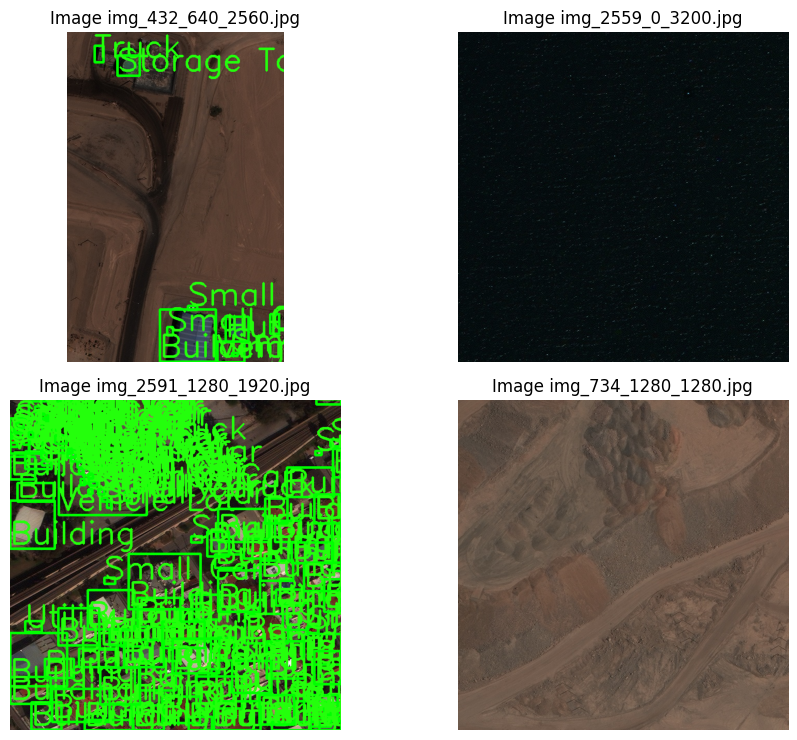

In [23]:
filenames = [x for x in os.listdir(save_images_fldr_pth) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, save_images_fldr_pth, max_images=4, no_cols=2, text=True,  class_map=class_map_dict)

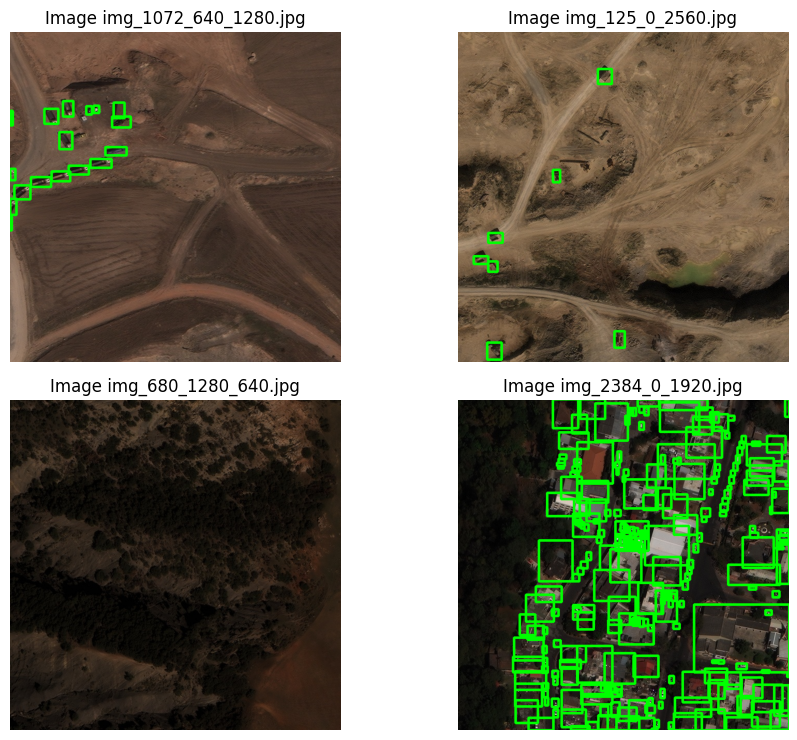

In [24]:
#without text labels
filenames = [x for x in os.listdir(save_images_fldr_pth) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, save_images_fldr_pth, max_images=4, no_cols=2, text=False)

## Do a train-test-val split

In [25]:
total_images = len(filenames)
indices = list(range(total_images))
random.shuffle(indices)

train_fraction = 1 - TEST_FRACTION - VAL_FRACTION
train_sp = int(np.floor(train_fraction * len(indices))) # The training-validation split
valid_sp = int(np.floor(VAL_FRACTION * len(indices))) + train_sp # The validation-test split
train_idx, val_idx, test_idx = indices[:train_sp], indices[train_sp:valid_sp], indices[valid_sp:]

print(' Training set size: \t', len(train_idx))
print(' Validation set size: \t', len(val_idx))
print(' Test set size: \t', len(test_idx))
print(' Total dataset: \t', total_images)

 Training set size: 	 19844
 Validation set size: 	 2480
 Test set size: 	 2482
 Total dataset: 	 24806


Write 3 text files into the Data folder with the file paths: train.txt, val.txt, test.txt  These are lists of absolute filepaths to the images, one line each path.  They can reside anywhere just so long as the relative paths in xview_yolo.yaml points to them.

In [26]:
files = ['train.txt', 'val.txt', 'test.txt']
splits = [train_idx, val_idx, test_idx]

for fn, split in zip(files, splits):
    txt_pth = cfg_fldr_pth / fn
    with open(txt_pth, 'a') as f:
        for ind in split:
            f.write(str(future_ds_img_fldr / filenames[ind]) + '\n')
        print(f'{fn[:-4]} file written to {txt_pth}, with {len(split) } samples')

train file written to /kaggle/working/YOLO_cfg/train.txt, with 19844 samples
val file written to /kaggle/working/YOLO_cfg/val.txt, with 2480 samples
test file written to /kaggle/working/YOLO_cfg/test.txt, with 2482 samples


## Write a .yaml file
Write a .yaml file pointing to the text file locations, and determining class names, number of categories location.
This is good practice, it means I don't need to move all the image files around just to change the training splits.
Also the .yml file gets updated automatically if anybody changes something like the number of classes.

In [27]:
config = {'train': str(future_ds_cfg_fldr / files[0]),
          'val': str(future_ds_cfg_fldr / files[1]),
          'test': str(future_ds_cfg_fldr / files[2]),
          'nc': len(class_map_dict),
          'names': class_map_dict
          }

with open(yolo_yaml_pth, "w") as file:
    yaml.dump(config, file, default_style=None, default_flow_style=False, sort_keys=False)
print(f'yaml file written to {yolo_yaml_pth}')

yaml file written to /kaggle/working/YOLO_cfg/xview_yolo.yaml


## Varification
Just checking the first few lines of the train.txt file

In [28]:
for split in ['train', 'val', 'test']:
    print(f'{split} text file')
    print_first_n_lines(cfg_fldr_pth / f'{split}.txt', 2)

train text file
/kaggle/input/xview-yolo-dataset/images/img_1770_1920_1920.jpg
/kaggle/input/xview-yolo-dataset/images/img_310_0_3840.jpg
val text file
/kaggle/input/xview-yolo-dataset/images/img_5_1280_2560.jpg
/kaggle/input/xview-yolo-dataset/images/img_1888_640_3200.jpg
test text file
/kaggle/input/xview-yolo-dataset/images/img_2278_0_640.jpg
/kaggle/input/xview-yolo-dataset/images/img_1418_1920_640.jpg


And the .yaml file

In [29]:
print_first_n_lines(yolo_yaml_pth, 10)

train: /kaggle/input/xview-yolo-dataset/YOLO_cfg/train.txt
val: /kaggle/input/xview-yolo-dataset/YOLO_cfg/val.txt
test: /kaggle/input/xview-yolo-dataset/YOLO_cfg/test.txt
nc: 60
names:
0: Fixed-wing Aircraft
1: Small Aircraft
2: Passenger/Cargo Plane
3: Helicopter
4: Passenger Vehicle


And a couple of annotations files

In [30]:
txt_fnames = [save_images_fldr_pth / x for x in os.listdir(save_images_fldr_pth) if x.endswith(".txt")]
text_list = random.choices(txt_fnames, k=2)
print(text_list)
for text_f in text_list:
    print(f'Reading {text_f}')
    print_first_n_lines(text_f, 3)  

[PosixPath('/kaggle/working/images/img_2530_1280_640.txt'), PosixPath('/kaggle/working/images/img_1216_2560_640.txt')]
Reading /kaggle/working/images/img_2530_1280_640.txt
Reading /kaggle/working/images/img_1216_2560_640.txt
48 0.0375 0.86707 0.075 0.26586
48 0.11172 0.98036 0.08906 0.03927
48 0.85234 0.96526 0.12656 0.06949


In [31]:
print(text_list)

[PosixPath('/kaggle/working/images/img_2530_1280_640.txt'), PosixPath('/kaggle/working/images/img_1216_2560_640.txt')]


And the csv file

In [32]:
out_data = pd.read_parquet(out_data_parquet_pth)
out_data.head()

,File_Name,Class_Name,Class_ID,x_center,y_center,width,height
0,img_283_2560_2560.txt,Building,48,0.97109,0.0168,0.05781,0.0336
1,img_283_2560_2560.txt,Building,48,0.47578,0.00692,0.09844,0.01383
2,img_283_2560_2560.txt,Building,48,0.7,0.07115,0.15313,0.14229
3,img_283_2560_2560.txt,Building,48,0.64062,0.20356,0.10312,0.10672
4,img_283_2560_2560.txt,Building,48,0.42266,0.1334,0.14844,0.20356


And the `.json`

In [33]:
with open(out_json_map_pth, "r") as json_file:
    loaded_dict = json.load(json_file)
print(loaded_dict)

{'0': 'Fixed-wing Aircraft', '1': 'Small Aircraft', '2': 'Passenger/Cargo Plane', '3': 'Helicopter', '4': 'Passenger Vehicle', '5': 'Small Car', '6': 'Bus', '7': 'Pickup Truck', '8': 'Utility Truck', '9': 'Truck', '10': 'Cargo Truck', '11': 'Truck Tractor w/ Box Trailer', '12': 'Truck Tractor', '13': 'Trailer', '14': 'Truck Tractor w/ Flatbed Trailer', '15': 'Truck Tractor w/ Liquid Tank', '16': 'Crane Truck', '17': 'Railway Vehicle', '18': 'Passenger Car', '19': 'Cargo/Container Car', '20': 'Flat Car', '21': 'Tank car', '22': 'Locomotive', '23': 'Maritime Vessel', '24': 'Motorboat', '25': 'Sailboat', '26': 'Tugboat', '27': 'Barge', '28': 'Fishing Vessel', '29': 'Ferry', '30': 'Yacht', '31': 'Container Ship', '32': 'Oil Tanker', '33': 'Engineering Vehicle', '34': 'Tower crane', '35': 'Container Crane', '36': 'Reach Stacker', '37': 'Straddle Carrier', '38': 'Mobile Crane', '39': 'Dump Truck', '40': 'Haul Truck', '41': 'Scraper/Tractor', '42': 'Front loader/Bulldozer', '43': 'Excavator',

## YOLO to COCO
Since it's not too much extra effort at this point, I'll re-format the dataframe into COCO geometry, and write a COCO `.json` file for people with that use in mind.  COCO format is explained [here](https://cocodataset.org/#format-data).  At the top level we mainly need these three objects:

images:  
`{"id": int, "width": int, "height": int, "file_name": str, }`   
annotations:  
`{"id": int, "image_id": int, "category_id": int, "area": float, "bbox": [x,y,width,height]}`  
categories:  
`[{"id": int, "name": str}]`

I'll copy the YOLO DataFrame, obtain the image widths, and create the BBox category:

In [34]:
image_data = {'width': widths, 'height' : heights, 'file_name':file_names}
im_df = pd.DataFrame(image_data)
im_df['id'] = im_df['file_name'].str.replace(r'\D', '', regex=True).astype(int)
im_df.head()

,width,height,file_name,id
0,640,640,img_2355_0_0.jpg,235500
1,640,640,img_2355_0_640.jpg,23550640
2,640,640,img_2355_0_1280.jpg,235501280
3,640,640,img_2355_0_1920.jpg,235501920
4,179,640,img_2355_0_2560.jpg,235502560


In [35]:
def row_to_dict(row):
    return {
        'id': row['id'],
        'width': row['width'],
        'height':row['height'],
        'file_name':row['file_name']
    }

im_list = im_df.apply(lambda row: row_to_dict(row), axis=1).tolist()
[print(val) for val in im_list[:4]]

{'id': 235500, 'width': 640, 'height': 640, 'file_name': 'img_2355_0_0.jpg'}
{'id': 23550640, 'width': 640, 'height': 640, 'file_name': 'img_2355_0_640.jpg'}
{'id': 235501280, 'width': 640, 'height': 640, 'file_name': 'img_2355_0_1280.jpg'}
{'id': 235501920, 'width': 640, 'height': 640, 'file_name': 'img_2355_0_1920.jpg'}


[None, None, None, None]

Merge the images dataframe with the annotations to work out the absolute pixel values, plus a bit more re-organising.

In [36]:
annotations_df = out_data.copy()
annotations_df['image_id'] = annotations_df['File_Name'].str.replace(r'\D', '', regex=True).astype(int)
annotations_df= annotations_df.rename(columns={'height': 'h', 'width': 'w'})
an_df = annotations_df.merge(im_df, left_on='image_id', right_on='id', how='left')
an_df['x_center']= (an_df['x_center'].astype(np.float64)*an_df['width']).round(decimals=0)
an_df['y_center']= (an_df['y_center'].astype(np.float64)*an_df['height']).round(decimals=0)
an_df['w']= (an_df['w'].astype(np.float64)*an_df['width']).round(decimals=0)
an_df['h']= (an_df['h'].astype(np.float64)*an_df['height']).round(decimals=0)
an_df['Class_ID']= an_df['Class_ID'].astype(int)
an_df = an_df.drop(columns=['File_Name', 'file_name', 'width', 'height', 'id'])
an_df['left'] = (an_df['x_center'] - an_df['w']/2).round(decimals=0)
an_df['top'] =  (an_df['y_center'] - an_df['h']/2).round(decimals=0)
an_df['bbox'] = ('[' + an_df['left'].astype(str) + ', ' 
              + an_df['top'].astype(str) + ', ' 
              + an_df['w'].astype(str) + ', '
              + an_df['h'].astype(str) + ']')
an_df['area'] = an_df['w'] * an_df['h']
an_df = an_df.drop(columns=['x_center', 'y_center', 'w', 'h', 'left', 'top', 'Class_Name'])
an_df.reset_index(inplace=True)
an_df.rename(columns={'index': 'id'}, inplace=True)
an_df.head()

,id,Class_ID,image_id,bbox,area
0,0,48,28325602560,"[602.0, 0.0, 37.0, 17.0]",629.0
1,1,48,28325602560,"[272.0, 0.0, 63.0, 7.0]",441.0
2,2,48,28325602560,"[399.0, 0.0, 98.0, 72.0]",7056.0
3,3,48,28325602560,"[377.0, 76.0, 66.0, 54.0]",3564.0
4,4,48,28325602560,"[224.0, 16.0, 95.0, 103.0]",9785.0


In [37]:
def row_to_dict(row):
    return {
        'id': row['id'],
        'image_id' : row['image_id'],
        'category_id': row['Class_ID'],
        'area':row['area'],
        'bbox':row['bbox']
    }

an_list = an_df.apply(lambda row: row_to_dict(row), axis=1).tolist()
print(an_list[:4])


[{'id': 0, 'image_id': 28325602560, 'category_id': 48, 'area': 629.0, 'bbox': '[602.0, 0.0, 37.0, 17.0]'}, {'id': 1, 'image_id': 28325602560, 'category_id': 48, 'area': 441.0, 'bbox': '[272.0, 0.0, 63.0, 7.0]'}, {'id': 2, 'image_id': 28325602560, 'category_id': 48, 'area': 7056.0, 'bbox': '[399.0, 0.0, 98.0, 72.0]'}, {'id': 3, 'image_id': 28325602560, 'category_id': 48, 'area': 3564.0, 'bbox': '[377.0, 76.0, 66.0, 54.0]'}]


The category mapping is just about in a convenient format already

In [38]:
cat_list = [{key:val} for key,val in class_map_dict.items()]
print(cat_list[:4])

[{0: 'Fixed-wing Aircraft'}, {1: 'Small Aircraft'}, {2: 'Passenger/Cargo Plane'}, {3: 'Helicopter'}]


Now I just need to combine the top level objects, and save to `.json`

In [39]:
out_json_data = {'images': im_list, 'annotations': an_list, 'categories': cat_list}
with open(coco_json_pth, 'w') as json_file:
    json.dump(out_json_data, json_file, indent=4)
    
for key, value in out_json_data.items():
    print(key, value[:5])

images [{'id': 235500, 'width': 640, 'height': 640, 'file_name': 'img_2355_0_0.jpg'}, {'id': 23550640, 'width': 640, 'height': 640, 'file_name': 'img_2355_0_640.jpg'}, {'id': 235501280, 'width': 640, 'height': 640, 'file_name': 'img_2355_0_1280.jpg'}, {'id': 235501920, 'width': 640, 'height': 640, 'file_name': 'img_2355_0_1920.jpg'}, {'id': 235502560, 'width': 179, 'height': 640, 'file_name': 'img_2355_0_2560.jpg'}]
annotations [{'id': 0, 'image_id': 28325602560, 'category_id': 48, 'area': 629.0, 'bbox': '[602.0, 0.0, 37.0, 17.0]'}, {'id': 1, 'image_id': 28325602560, 'category_id': 48, 'area': 441.0, 'bbox': '[272.0, 0.0, 63.0, 7.0]'}, {'id': 2, 'image_id': 28325602560, 'category_id': 48, 'area': 7056.0, 'bbox': '[399.0, 0.0, 98.0, 72.0]'}, {'id': 3, 'image_id': 28325602560, 'category_id': 48, 'area': 3564.0, 'bbox': '[377.0, 76.0, 66.0, 54.0]'}, {'id': 4, 'image_id': 28325602560, 'category_id': 48, 'area': 9785.0, 'bbox': '[224.0, 16.0, 95.0, 103.0]'}]
categories [{0: 'Fixed-wing Airc